In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/RealTrain/'

In [3]:
train = pd.read_csv(TRAIN_PATH + 'data.csv')
display(train.head())

,filename,label,T1
0,Y1.jpg,1,1
1,Y10.jpg,1,1
2,Y101.jpg,1,1
3,Y103.jpg,1,1
4,Y104.jpg,1,1


In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=10
    num_workers=0
    model_name='resnext50_32x4d'
    size=200
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=20
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    # batch_size=32
    batch_size = 2
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=43
    target_size=1
    # target_cols=['label', 'T1']
    target_cols=['label']
    # target_cols=['T1']
    n_fold=4
    trn_fold=[0, 1, 2]
    train=True
    
if CFG.debug:
    CFG.epochs = 1

In [5]:
# ====================================================
# Library
# ====================================================
import sys
# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
from io import BytesIO
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [7]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # display(y_true)
    # display(y_pred)
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [8]:
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['filename'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
  folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
3    56
dtype: int64

,filename,label,T1,fold
0,Y1.jpg,1,1,2
1,Y10.jpg,1,1,1
2,Y101.jpg,1,1,3
3,Y103.jpg,1,1,1
4,Y104.jpg,1,1,0
...,...,...,...,...
222,No12.jpg,0,0,3
223,No14.jpg,0,0,1
224,No15.jpg,0,0,0
225,No21.jpg,0,0,0


In [9]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['filename'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = torch.tensor(self.labels[idx]).float()
        # if(label[0].item() == 1):
        #   image = cv2.imread(TRAIN_PATH + 'yes/' + file_name)
        #   # label = np.array([1]).astype(np.float)
        # else:
        #   image = cv2.imread(TRAIN_PATH + 'no/' + file_name)
        #   # label = np.array([0]).astype(np.float)
        image = cv2.imread(TRAIN_PATH + 'train/' + file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

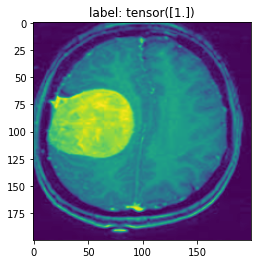

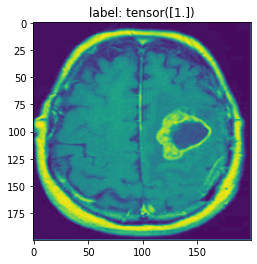

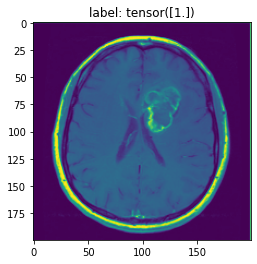

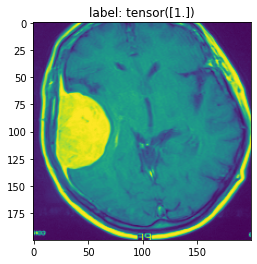

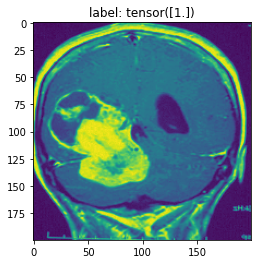

In [11]:
train_dataset = TrainDataset(folds, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [12]:

tst_idx = folds[folds['fold'] == CFG.n_fold - 1].index

test_fold = folds.loc[tst_idx].reset_index(drop=True)
_test_fold = test_fold.copy(deep=True)
test_dataset = TrainDataset(_test_fold, transform=get_transforms(data='valid'))

folds = folds[folds['fold'].isin([i for i in range(CFG.n_fold - 1)])]
display(folds.groupby('fold').size())
display(folds)

fold
0    57
1    57
2    57
dtype: int64

,filename,label,T1,fold
0,Y1.jpg,1,1,2
1,Y10.jpg,1,1,1
3,Y103.jpg,1,1,1
4,Y104.jpg,1,1,0
6,Y106.jpg,1,1,2
...,...,...,...,...
220,no 7.jpeg,0,0,0
221,no 90.jpg,0,0,0
223,No14.jpg,0,0,1
224,No15.jpg,0,0,0


In [13]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if(pretrained):
          self.model.load_state_dict(torch.load('../models/resnext50_32x4d_a1h-0146ab0a.pth'))
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        # loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [15]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    test_loader = DataLoader(test_dataset, 
                        batch_size=CFG.batch_size, 
                        shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # test
    test_labels = test_fold[CFG.target_cols].values
    avg_test_loss, preds = valid_fn(test_loader, model, criterion, device)
    score, scores = get_score(test_labels, preds)
    
    LOGGER.info(f"========== fold: {fold} test ==========")
    LOGGER.info(f'test: avg_val_loss: {avg_test_loss:.4f}')
    LOGGER.info(f'test: Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

    return valid_folds

In [16]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold - 1):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                # display(_oof_df)
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [17]:
main()

========== fold: 0 training ==========


Epoch: [1][0/57] Data 0.186 (0.186) Elapsed 0m 2s (remain 2m 25s) Loss: 0.6910(0.6910) Grad: nan  
Epoch: [1][10/57] Data 0.024 (0.035) Elapsed 0m 6s (remain 0m 28s) Loss: 0.6681(0.6871) Grad: 220394.6719  
Epoch: [1][20/57] Data 0.023 (0.031) Elapsed 0m 12s (remain 0m 20s) Loss: 0.6852(0.6894) Grad: 112291.2734  
Epoch: [1][30/57] Data 0.015 (0.027) Elapsed 0m 16s (remain 0m 14s) Loss: 0.7045(0.6921) Grad: 48480.8516  
Epoch: [1][40/57] Data 0.015 (0.027) Elapsed 0m 21s (remain 0m 8s) Loss: 0.6448(0.6878) Grad: 54978.7930  
Epoch: [1][50/57] Data 0.022 (0.025) Elapsed 0m 26s (remain 0m 3s) Loss: 0.6048(0.6820) Grad: 59222.6992  
Epoch: [1][56/57] Data 0.018 (0.025) Elapsed 0m 28s (remain 0m 0s) Loss: 0.7133(0.6730) Grad: 99873.3672  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5211(0.5211) 
EVAL: [10/15] Data 0.036 (0.035) Elapsed 0m 1s (remain 0m 0s) Loss: 0.5611(0.6018) 
EVAL: [14/15] Data 0.013 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7853(0.6525) 


Epoch 1 - avg_train_loss: 0.6730  avg_val_loss: 0.6525  time: 31s
Epoch 1 - Score: 0.7610  Scores: [0.761]
Epoch 1 - Save Best Loss: 0.6525 Model


Epoch: [2][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 21s) Loss: 0.5443(0.5443) Grad: inf  
Epoch: [2][10/57] Data 0.012 (0.018) Elapsed 0m 5s (remain 0m 21s) Loss: 0.4952(0.5604) Grad: 175015.3750  
Epoch: [2][20/57] Data 0.016 (0.017) Elapsed 0m 10s (remain 0m 17s) Loss: 0.6763(0.5748) Grad: inf  
Epoch: [2][30/57] Data 0.017 (0.017) Elapsed 0m 14s (remain 0m 12s) Loss: 1.0758(0.5718) Grad: 261406.7812  
Epoch: [2][40/57] Data 0.012 (0.017) Elapsed 0m 20s (remain 0m 7s) Loss: 0.6853(0.6291) Grad: 178213.8906  
Epoch: [2][50/57] Data 0.017 (0.017) Elapsed 0m 24s (remain 0m 2s) Loss: 0.5944(0.6468) Grad: 217332.4219  
Epoch: [2][56/57] Data 0.014 (0.018) Elapsed 0m 27s (remain 0m 0s) Loss: 0.4156(0.6468) Grad: 88480.0078  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 1s) Loss: 0.4501(0.4501) 
EVAL: [10/15] Data 0.040 (0.050) Elapsed 0m 1s (remain 0m 0s) Loss: 0.4669(0.5470) 
EVAL: [14/15] Data 0.008 (0.045) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8625(0.6193) 


Epoch 2 - avg_train_loss: 0.6468  avg_val_loss: 0.6193  time: 30s
Epoch 2 - Score: 0.8857  Scores: [0.8857]
Epoch 2 - Save Best Loss: 0.6193 Model


Epoch: [3][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 23s) Loss: 0.4508(0.4508) Grad: inf  
Epoch: [3][10/57] Data 0.018 (0.015) Elapsed 0m 5s (remain 0m 21s) Loss: 0.4059(0.6219) Grad: 126537.7344  
Epoch: [3][20/57] Data 0.014 (0.017) Elapsed 0m 10s (remain 0m 17s) Loss: 1.0382(0.6136) Grad: 133517.6094  
Epoch: [3][30/57] Data 0.024 (0.018) Elapsed 0m 15s (remain 0m 13s) Loss: 0.6247(0.6277) Grad: 157626.5625  
Epoch: [3][40/57] Data 0.018 (0.018) Elapsed 0m 20s (remain 0m 8s) Loss: 0.5060(0.6210) Grad: 94957.4844  
Epoch: [3][50/57] Data 0.020 (0.018) Elapsed 0m 26s (remain 0m 3s) Loss: 0.3827(0.6146) Grad: 93916.9453  
Epoch: [3][56/57] Data 0.015 (0.019) Elapsed 0m 29s (remain 0m 0s) Loss: 0.5450(0.6177) Grad: 208584.0000  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 1s) Loss: 0.3580(0.3580) 
EVAL: [10/15] Data 0.047 (0.035) Elapsed 0m 1s (remain 0m 0s) Loss: 0.5355(0.5186) 
EVAL: [14/15] Data 0.012 (0.038) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8865(0.6077) 


Epoch 3 - avg_train_loss: 0.6177  avg_val_loss: 0.6077  time: 32s
Epoch 3 - Score: 0.8701  Scores: [0.8701]
Epoch 3 - Save Best Loss: 0.6077 Model


Epoch: [4][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 24s) Loss: 0.9979(0.9979) Grad: nan  
Epoch: [4][10/57] Data 0.015 (0.016) Elapsed 0m 5s (remain 0m 24s) Loss: 0.8458(0.6257) Grad: inf  
Epoch: [4][20/57] Data 0.014 (0.016) Elapsed 0m 11s (remain 0m 19s) Loss: 0.5539(0.6027) Grad: 167648.6719  
Epoch: [4][30/57] Data 0.013 (0.016) Elapsed 0m 16s (remain 0m 13s) Loss: 0.5745(0.5639) Grad: 219365.9219  
Epoch: [4][40/57] Data 0.013 (0.017) Elapsed 0m 21s (remain 0m 8s) Loss: 0.5083(0.5655) Grad: 131113.4219  
Epoch: [4][50/57] Data 0.013 (0.017) Elapsed 0m 27s (remain 0m 3s) Loss: 0.3982(0.5416) Grad: 56056.0469  
Epoch: [4][56/57] Data 0.013 (0.018) Elapsed 0m 30s (remain 0m 0s) Loss: 1.4006(0.5771) Grad: 216753.4844  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2655(0.2655) 
EVAL: [10/15] Data 0.056 (0.037) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3793(0.4509) 
EVAL: [14/15] Data 0.012 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8420(0.5440) 


Epoch 4 - avg_train_loss: 0.5771  avg_val_loss: 0.5440  time: 33s
Epoch 4 - Score: 0.9442  Scores: [0.9442]
Epoch 4 - Save Best Loss: 0.5440 Model


Epoch: [5][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 24s) Loss: 0.4310(0.4310) Grad: inf  
Epoch: [5][10/57] Data 0.013 (0.015) Elapsed 0m 6s (remain 0m 25s) Loss: 0.8172(0.5804) Grad: 736657.0000  
Epoch: [5][20/57] Data 0.012 (0.016) Elapsed 0m 11s (remain 0m 20s) Loss: 0.4519(0.6113) Grad: 269896.0938  
Epoch: [5][30/57] Data 0.017 (0.017) Elapsed 0m 17s (remain 0m 14s) Loss: 0.4578(0.6469) Grad: 144119.9375  
Epoch: [5][40/57] Data 0.014 (0.017) Elapsed 0m 22s (remain 0m 8s) Loss: 0.5667(0.6089) Grad: 271979.7188  
Epoch: [5][50/57] Data 0.012 (0.018) Elapsed 0m 28s (remain 0m 3s) Loss: 1.2496(0.5907) Grad: 205717.7500  
Epoch: [5][56/57] Data 0.013 (0.018) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4003(0.5655) Grad: 35821.9414  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2947(0.2947) 
EVAL: [10/15] Data 0.051 (0.040) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3907(0.4816) 
EVAL: [14/15] Data 0.009 (0.039) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8190(0.5718) 


Epoch 5 - avg_train_loss: 0.5655  avg_val_loss: 0.5718  time: 34s
Epoch 5 - Score: 0.8857  Scores: [0.8857]


Epoch: [6][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 25s) Loss: 0.4945(0.4945) Grad: inf  
Epoch: [6][10/57] Data 0.012 (0.015) Elapsed 0m 5s (remain 0m 23s) Loss: 0.3083(0.6313) Grad: 170040.5625  
Epoch: [6][20/57] Data 0.013 (0.017) Elapsed 0m 11s (remain 0m 18s) Loss: 0.4830(0.5433) Grad: 59767.0000  
Epoch: [6][30/57] Data 0.018 (0.017) Elapsed 0m 17s (remain 0m 14s) Loss: 0.2971(0.5663) Grad: 41832.0078  
Epoch: [6][40/57] Data 0.018 (0.017) Elapsed 0m 22s (remain 0m 8s) Loss: 0.4459(0.5333) Grad: 55285.4375  
Epoch: [6][50/57] Data 0.126 (0.037) Elapsed 0m 30s (remain 0m 3s) Loss: 0.4769(0.5288) Grad: 62566.7812  
Epoch: [6][56/57] Data 0.027 (0.043) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4921(0.5251) Grad: 77865.6875  
EVAL: [0/15] Data 0.097 (0.097) Elapsed 0m 0s (remain 0m 5s) Loss: 0.2054(0.2054) 
EVAL: [10/15] Data 0.062 (0.067) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3672(0.4394) 
EVAL: [14/15] Data 0.007 (0.058) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8121(0.5417) 


Epoch 6 - avg_train_loss: 0.5251  avg_val_loss: 0.5417  time: 39s
Epoch 6 - Score: 0.9351  Scores: [0.9351]
Epoch 6 - Save Best Loss: 0.5417 Model


Epoch: [7][0/57] Data 0.035 (0.035) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2452(0.2452) Grad: inf  
Epoch: [7][10/57] Data 0.014 (0.022) Elapsed 0m 6s (remain 0m 28s) Loss: 0.4922(0.4473) Grad: 262854.6250  
Epoch: [7][20/57] Data 0.018 (0.022) Elapsed 0m 13s (remain 0m 22s) Loss: 0.4333(0.4772) Grad: 93316.9453  
Epoch: [7][30/57] Data 0.019 (0.020) Elapsed 0m 18s (remain 0m 15s) Loss: 0.4152(0.5488) Grad: 91046.1641  
Epoch: [7][40/57] Data 0.013 (0.021) Elapsed 0m 25s (remain 0m 9s) Loss: 0.4896(0.5282) Grad: 202924.9531  
Epoch: [7][50/57] Data 0.012 (0.020) Elapsed 0m 31s (remain 0m 3s) Loss: 1.4017(0.5445) Grad: 314031.4688  
Epoch: [7][56/57] Data 0.011 (0.020) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4724(0.5298) Grad: 125526.8047  
EVAL: [0/15] Data 0.050 (0.050) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2182(0.2182) 
EVAL: [10/15] Data 0.055 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3842(0.4432) 
EVAL: [14/15] Data 0.014 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7954(0.5521) 


Epoch 7 - avg_train_loss: 0.5298  avg_val_loss: 0.5521  time: 37s
Epoch 7 - Score: 0.9000  Scores: [0.9]


Epoch: [8][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 28s) Loss: 0.4524(0.4524) Grad: inf  
Epoch: [8][10/57] Data 0.016 (0.017) Elapsed 0m 6s (remain 0m 26s) Loss: 0.2859(0.5653) Grad: 153981.8438  
Epoch: [8][20/57] Data 0.012 (0.018) Elapsed 0m 12s (remain 0m 21s) Loss: 1.2816(0.5933) Grad: 417806.5625  
Epoch: [8][30/57] Data 0.023 (0.019) Elapsed 0m 19s (remain 0m 16s) Loss: 0.4205(0.5361) Grad: 120987.6562  
Epoch: [8][40/57] Data 0.033 (0.055) Elapsed 0m 28s (remain 0m 11s) Loss: 0.4187(0.5049) Grad: 101047.0078  
Epoch: [8][50/57] Data 0.018 (0.048) Elapsed 0m 34s (remain 0m 4s) Loss: 1.3808(0.5418) Grad: 331186.6875  
Epoch: [8][56/57] Data 0.012 (0.046) Elapsed 0m 37s (remain 0m 0s) Loss: 0.3908(0.5344) Grad: 50740.9688  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2226(0.2226) 
EVAL: [10/15] Data 0.034 (0.036) Elapsed 0m 1s (remain 0m 0s) Loss: 0.3860(0.4481) 
EVAL: [14/15] Data 0.014 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7948(0.5389) 


Epoch 8 - avg_train_loss: 0.5344  avg_val_loss: 0.5389  time: 40s
Epoch 8 - Score: 0.9442  Scores: [0.9442]
Epoch 8 - Save Best Loss: 0.5389 Model


Epoch: [9][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 23s) Loss: 0.4898(0.4898) Grad: inf  
Epoch: [9][10/57] Data 0.012 (0.022) Elapsed 0m 6s (remain 0m 29s) Loss: 0.2371(0.6347) Grad: 36182.6133  
Epoch: [9][20/57] Data 0.017 (0.021) Elapsed 0m 13s (remain 0m 22s) Loss: 0.2744(0.4726) Grad: 106546.2266  
Epoch: [9][30/57] Data 0.013 (0.019) Elapsed 0m 19s (remain 0m 16s) Loss: 1.6124(0.4698) Grad: 315226.4062  
Epoch: [9][40/57] Data 0.015 (0.020) Elapsed 0m 25s (remain 0m 9s) Loss: 1.0548(0.5058) Grad: 647251.5625  
Epoch: [9][50/57] Data 0.022 (0.021) Elapsed 0m 31s (remain 0m 3s) Loss: 0.5595(0.5470) Grad: 344719.2812  
Epoch: [9][56/57] Data 0.012 (0.021) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3381(0.5407) Grad: 31916.5781  
EVAL: [0/15] Data 0.041 (0.041) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2152(0.2152) 
EVAL: [10/15] Data 0.047 (0.044) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3560(0.4272) 
EVAL: [14/15] Data 0.011 (0.041) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7093(0.5232) 


Epoch 9 - avg_train_loss: 0.5407  avg_val_loss: 0.5232  time: 39s
Epoch 9 - Score: 0.9364  Scores: [0.9364]
Epoch 9 - Save Best Loss: 0.5232 Model


Epoch: [10][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2085(0.2085) Grad: inf  
Epoch: [10][10/57] Data 0.014 (0.016) Elapsed 0m 6s (remain 0m 27s) Loss: 0.4788(0.3993) Grad: 473375.3750  
Epoch: [10][20/57] Data 0.012 (0.019) Elapsed 0m 12s (remain 0m 21s) Loss: 0.3549(0.4951) Grad: 61843.6875  
Epoch: [10][30/57] Data 0.014 (0.019) Elapsed 0m 18s (remain 0m 15s) Loss: 0.3094(0.5182) Grad: 78476.7500  
Epoch: [10][40/57] Data 0.016 (0.018) Elapsed 0m 25s (remain 0m 9s) Loss: 0.2962(0.4737) Grad: 72052.9375  
Epoch: [10][50/57] Data 0.016 (0.018) Elapsed 0m 31s (remain 0m 3s) Loss: 1.5678(0.4662) Grad: 162628.7344  
Epoch: [10][56/57] Data 0.011 (0.018) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1702(0.4893) Grad: 30640.1152  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1960(0.1960) 
EVAL: [10/15] Data 0.031 (0.036) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3660(0.4225) 
EVAL: [14/15] Data 0.009 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5721(0.4818

Epoch 10 - avg_train_loss: 0.4893  avg_val_loss: 0.4818  time: 38s
Epoch 10 - Score: 0.9442  Scores: [0.9442]
Epoch 10 - Save Best Loss: 0.4818 Model


Epoch: [11][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 26s) Loss: 1.6281(1.6281) Grad: nan  
Epoch: [11][10/57] Data 0.013 (0.017) Elapsed 0m 7s (remain 0m 30s) Loss: 1.9099(0.8550) Grad: 509306.5625  
Epoch: [11][20/57] Data 0.014 (0.019) Elapsed 0m 13s (remain 0m 22s) Loss: 0.2988(0.6709) Grad: 68942.6641  
Epoch: [11][30/57] Data 0.016 (0.019) Elapsed 0m 19s (remain 0m 16s) Loss: 0.3021(0.5343) Grad: 173467.5000  
Epoch: [11][40/57] Data 0.014 (0.018) Elapsed 0m 25s (remain 0m 10s) Loss: 0.2262(0.4644) Grad: 147180.1250  
Epoch: [11][50/57] Data 0.011 (0.018) Elapsed 0m 32s (remain 0m 3s) Loss: 0.1841(0.4866) Grad: 23466.3340  
Epoch: [11][56/57] Data 0.017 (0.018) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1513(0.4941) Grad: 19083.2773  
EVAL: [0/15] Data 0.035 (0.035) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2157(0.2157) 
EVAL: [10/15] Data 0.036 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.6371(0.5149) 
EVAL: [14/15] Data 0.009 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3403(0.50

Epoch 11 - avg_train_loss: 0.4941  avg_val_loss: 0.5052  time: 39s
Epoch 11 - Score: 0.8364  Scores: [0.8364]


Epoch: [12][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 27s) Loss: 1.9261(1.9261) Grad: nan  
Epoch: [12][10/57] Data 0.013 (0.015) Elapsed 0m 7s (remain 0m 29s) Loss: 0.1446(0.4626) Grad: 61210.1758  
Epoch: [12][20/57] Data 0.014 (0.016) Elapsed 0m 13s (remain 0m 23s) Loss: 0.1141(0.4420) Grad: 8913.6270  
Epoch: [12][30/57] Data 0.014 (0.016) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0892(0.4163) Grad: 16757.2891  
Epoch: [12][40/57] Data 0.012 (0.016) Elapsed 0m 26s (remain 0m 10s) Loss: 0.0383(0.4557) Grad: 4514.3569  
Epoch: [12][50/57] Data 0.014 (0.016) Elapsed 0m 32s (remain 0m 3s) Loss: 0.1590(0.4244) Grad: 108154.5625  
Epoch: [12][56/57] Data 0.012 (0.017) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0220(0.3950) Grad: 5603.2812  
EVAL: [0/15] Data 0.037 (0.037) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1949(0.1949) 
EVAL: [10/15] Data 0.034 (0.036) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0261(0.5116) 
EVAL: [14/15] Data 0.014 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0026(0.4243) 


Epoch 12 - avg_train_loss: 0.3950  avg_val_loss: 0.4243  time: 39s
Epoch 12 - Score: 0.9610  Scores: [0.961]
Epoch 12 - Save Best Loss: 0.4243 Model


Epoch: [13][0/57] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0144(0.0144) Grad: 84095.2031  
Epoch: [13][10/57] Data 0.014 (0.018) Elapsed 0m 6s (remain 0m 26s) Loss: 0.9186(0.6616) Grad: inf  
Epoch: [13][20/57] Data 0.013 (0.017) Elapsed 0m 12s (remain 0m 21s) Loss: 0.4700(0.5766) Grad: 324770.1562  
Epoch: [13][30/57] Data 0.015 (0.017) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0250(0.6845) Grad: 23210.9375  
Epoch: [13][40/57] Data 0.017 (0.017) Elapsed 0m 25s (remain 0m 10s) Loss: 0.0832(0.6854) Grad: 22010.7559  
Epoch: [13][50/57] Data 0.011 (0.017) Elapsed 0m 32s (remain 0m 3s) Loss: 3.0953(0.6863) Grad: 284521.9375  
Epoch: [13][56/57] Data 0.024 (0.018) Elapsed 0m 36s (remain 0m 0s) Loss: 0.2171(0.6228) Grad: inf  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0669(0.0669) 
EVAL: [10/15] Data 0.041 (0.050) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0688(0.6087) 
EVAL: [14/15] Data 0.011 (0.045) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.5162) 


Epoch 13 - avg_train_loss: 0.6228  avg_val_loss: 0.5162  time: 40s
Epoch 13 - Score: 0.9299  Scores: [0.9299]


Epoch: [14][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 33s) Loss: 2.7627(2.7627) Grad: nan  
Epoch: [14][10/57] Data 0.011 (0.024) Elapsed 0m 8s (remain 0m 33s) Loss: 1.3235(0.6962) Grad: inf  
Epoch: [14][20/57] Data 0.011 (0.019) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0021(0.5316) Grad: 312.5049  
Epoch: [14][30/57] Data 0.026 (0.020) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0013(0.4202) Grad: 139.1313  
Epoch: [14][40/57] Data 0.023 (0.021) Elapsed 0m 28s (remain 0m 11s) Loss: 0.1144(0.4908) Grad: 101190.7109  
Epoch: [14][50/57] Data 0.012 (0.022) Elapsed 0m 35s (remain 0m 4s) Loss: 0.2445(0.5682) Grad: 328473.0000  
Epoch: [14][56/57] Data 0.015 (0.022) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0025(0.6162) Grad: 540.4104  
EVAL: [0/15] Data 0.033 (0.033) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0583(0.0583) 
EVAL: [10/15] Data 0.037 (0.039) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0635(0.3327) 
EVAL: [14/15] Data 0.011 (0.037) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0001(0.3343) 


Epoch 14 - avg_train_loss: 0.6162  avg_val_loss: 0.3343  time: 43s
Epoch 14 - Score: 0.8909  Scores: [0.8909]
Epoch 14 - Save Best Loss: 0.3343 Model


Epoch: [15][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0291(0.0291) Grad: 327241.2188  
Epoch: [15][10/57] Data 0.016 (0.027) Elapsed 0m 7s (remain 0m 31s) Loss: 1.3805(0.5776) Grad: inf  
Epoch: [15][20/57] Data 0.011 (0.023) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0418(0.6324) Grad: 51728.3789  
Epoch: [15][30/57] Data 0.017 (0.022) Elapsed 0m 21s (remain 0m 17s) Loss: 2.4264(0.7740) Grad: 385411.1875  
Epoch: [15][40/57] Data 0.014 (0.021) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0018(0.6453) Grad: 271.9022  
Epoch: [15][50/57] Data 0.013 (0.021) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0162(0.6379) Grad: 4031.9563  
Epoch: [15][56/57] Data 0.014 (0.021) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0012(0.7038) Grad: 159.4241  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0322(0.0322) 
EVAL: [10/15] Data 0.036 (0.046) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7225(0.3300) 
EVAL: [14/15] Data 0.006 (0.041) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0002(0.3833) 


Epoch 15 - avg_train_loss: 0.7038  avg_val_loss: 0.3833  time: 42s
Epoch 15 - Score: 0.9312  Scores: [0.9312]


Epoch: [16][0/57] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0011(0.0011) Grad: 5157.0747  
Epoch: [16][10/57] Data 0.012 (0.019) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0205(0.5289) Grad: 133383.5781  
Epoch: [16][20/57] Data 0.017 (0.018) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0030(0.5976) Grad: 2199.3706  
Epoch: [16][30/57] Data 0.011 (0.017) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0008(0.6956) Grad: 90.8218  
Epoch: [16][40/57] Data 0.026 (0.017) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0051(0.6187) Grad: 526.0610  
Epoch: [16][50/57] Data 0.014 (0.017) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0053(0.7133) Grad: 916.9690  
Epoch: [16][56/57] Data 0.012 (0.018) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0028(0.6855) Grad: 1125.8907  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0938(0.0938) 
EVAL: [10/15] Data 0.036 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.6773(0.3727) 
EVAL: [14/15] Data 0.015 (0.032) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0002(0.3622) 


Epoch 16 - avg_train_loss: 0.6855  avg_val_loss: 0.3622  time: 41s
Epoch 16 - Score: 0.9221  Scores: [0.9221]


Epoch: [17][0/57] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 30s) Loss: 2.2159(2.2159) Grad: nan  
Epoch: [17][10/57] Data 0.013 (0.015) Elapsed 0m 6s (remain 0m 27s) Loss: 0.0043(0.6320) Grad: 2695.5474  
Epoch: [17][20/57] Data 0.014 (0.015) Elapsed 0m 13s (remain 0m 22s) Loss: 0.0008(0.5520) Grad: 248.2801  
Epoch: [17][30/57] Data 0.012 (0.015) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0036(0.5023) Grad: 610.8733  
Epoch: [17][40/57] Data 0.013 (0.015) Elapsed 0m 26s (remain 0m 10s) Loss: 2.0571(0.5635) Grad: 246451.3906  
Epoch: [17][50/57] Data 0.009 (0.016) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0008(0.4884) Grad: 75.8798  
Epoch: [17][56/57] Data 0.015 (0.016) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0061(0.4375) Grad: 2348.6121  
EVAL: [0/15] Data 0.039 (0.039) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0694(0.0694) 
EVAL: [10/15] Data 0.028 (0.032) Elapsed 0m 2s (remain 0m 1s) Loss: 2.4275(0.8271) 
EVAL: [14/15] Data 0.013 (0.031) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.6735) 


Epoch 17 - avg_train_loss: 0.4375  avg_val_loss: 0.6735  time: 41s
Epoch 17 - Score: 0.9221  Scores: [0.9221]


Epoch: [18][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 33s) Loss: 3.6806(3.6806) Grad: nan  
Epoch: [18][10/57] Data 0.010 (0.014) Elapsed 0m 7s (remain 0m 30s) Loss: 1.2138(0.9552) Grad: inf  
Epoch: [18][20/57] Data 0.018 (0.017) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0009(0.5484) Grad: 84.9643  
Epoch: [18][30/57] Data 0.014 (0.018) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0020(0.4582) Grad: 186.7443  
Epoch: [18][40/57] Data 0.012 (0.017) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0033(0.5191) Grad: 435.0662  
Epoch: [18][50/57] Data 0.011 (0.018) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0011(0.4235) Grad: 194.0809  
Epoch: [18][56/57] Data 0.018 (0.018) Elapsed 0m 38s (remain 0m 0s) Loss: 0.3729(0.4433) Grad: 264257.3125  
EVAL: [0/15] Data 0.034 (0.034) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0427(0.0427) 
EVAL: [10/15] Data 0.031 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8675(0.3725) 
EVAL: [14/15] Data 0.011 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.3334) 


Epoch 18 - avg_train_loss: 0.4433  avg_val_loss: 0.3334  time: 42s
Epoch 18 - Score: 0.9455  Scores: [0.9455]
Epoch 18 - Save Best Loss: 0.3334 Model


Epoch: [19][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0005(0.0005) Grad: 1806.2573  
Epoch: [19][10/57] Data 0.012 (0.016) Elapsed 0m 7s (remain 0m 29s) Loss: 0.0138(1.1433) Grad: 24663.8574  
Epoch: [19][20/57] Data 0.019 (0.017) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0032(0.6825) Grad: 3548.1750  
Epoch: [19][30/57] Data 0.020 (0.017) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0008(0.4647) Grad: 278.1570  
Epoch: [19][40/57] Data 0.011 (0.016) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0041(0.5555) Grad: 1420.5356  
Epoch: [19][50/57] Data 0.011 (0.016) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0027(0.5244) Grad: 537.9434  
Epoch: [19][56/57] Data 0.017 (0.017) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0029(0.4694) Grad: 1061.3010  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1230(0.1230) 
EVAL: [10/15] Data 0.027 (0.036) Elapsed 0m 2s (remain 0m 1s) Loss: 1.0050(0.5017) 
EVAL: [14/15] Data 0.007 (0.035) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.4304) 

Epoch 19 - avg_train_loss: 0.4694  avg_val_loss: 0.4304  time: 42s
Epoch 19 - Score: 0.9299  Scores: [0.9299]


Epoch: [20][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0009(0.0009) Grad: 4634.4702  
Epoch: [20][10/57] Data 0.012 (0.015) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0058(0.3325) Grad: 91090.0000  
Epoch: [20][20/57] Data 0.011 (0.017) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0048(0.3369) Grad: 27111.5000  
Epoch: [20][30/57] Data 0.024 (0.017) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0488(0.5662) Grad: 115650.6016  
Epoch: [20][40/57] Data 0.011 (0.016) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0030(0.4418) Grad: 816.4732  
Epoch: [20][50/57] Data 0.010 (0.016) Elapsed 0m 34s (remain 0m 4s) Loss: 1.3840(0.5514) Grad: inf  
Epoch: [20][56/57] Data 0.012 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 0.5442(0.5105) Grad: 354750.2500  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1103(0.1103) 
EVAL: [10/15] Data 0.031 (0.031) Elapsed 0m 2s (remain 0m 1s) Loss: 2.0830(0.8873) 
EVAL: [14/15] Data 0.011 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.7316) 

Epoch 20 - avg_train_loss: 0.5105  avg_val_loss: 0.7316  time: 42s
Epoch 20 - Score: 0.9169  Scores: [0.9169]


EVAL: [0/28] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 2s) Loss: 1.1664(1.1664) 
EVAL: [10/28] Data 0.014 (0.017) Elapsed 0m 1s (remain 0m 2s) Loss: 0.8494(1.0243) 
EVAL: [20/28] Data 0.024 (0.019) Elapsed 0m 2s (remain 0m 0s) Loss: 1.9145(0.7547) 
EVAL: [27/28] Data 0.017 (0.019) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0019(0.7219) 


========== fold: 0 test ==========
test: avg_val_loss: 0.7219
test: Score: 0.9565  Scores: [0.9565]
========== fold: 0 result ==========
Score: 0.9455  Scores: [0.9455]
========== fold: 1 training ==========


Epoch: [1][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 22s) Loss: 0.6408(0.6408) Grad: nan  
Epoch: [1][10/57] Data 0.011 (0.013) Elapsed 0m 8s (remain 0m 37s) Loss: 0.7574(0.6872) Grad: 345233.0625  
Epoch: [1][20/57] Data 0.013 (0.014) Elapsed 0m 16s (remain 0m 28s) Loss: 0.6900(0.6921) Grad: 342951.5938  
Epoch: [1][30/57] Data 0.015 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.6836(0.6889) Grad: 250135.7656  
Epoch: [1][40/57] Data 0.021 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.6967(0.6851) Grad: 153591.0312  
Epoch: [1][50/57] Data 0.012 (0.016) Elapsed 0m 40s (remain 0m 4s) Loss: 0.5767(0.6814) Grad: 182143.7031  
Epoch: [1][56/57] Data 0.012 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.8526(0.6795) Grad: 437689.5625  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.8289(0.8289) 
EVAL: [10/15] Data 0.031 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6933(0.7822) 
EVAL: [14/15] Data 0.009 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1097(0.7494) 

Epoch 1 - avg_train_loss: 0.6795  avg_val_loss: 0.7494  time: 49s
Epoch 1 - Score: 0.6324  Scores: [0.6324]
Epoch 1 - Save Best Loss: 0.7494 Model


Epoch: [2][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 28s) Loss: 0.8508(0.8508) Grad: nan  
Epoch: [2][10/57] Data 0.010 (0.013) Elapsed 0m 6s (remain 0m 28s) Loss: 0.7231(0.7202) Grad: 201750.7031  
Epoch: [2][20/57] Data 0.012 (0.015) Elapsed 0m 13s (remain 0m 22s) Loss: 0.7247(0.7013) Grad: 144797.3750  
Epoch: [2][30/57] Data 0.012 (0.015) Elapsed 0m 19s (remain 0m 16s) Loss: 0.4943(0.6716) Grad: 41238.4453  
Epoch: [2][40/57] Data 0.012 (0.015) Elapsed 0m 26s (remain 0m 10s) Loss: 0.4507(0.6569) Grad: 113188.0391  
Epoch: [2][50/57] Data 0.014 (0.015) Elapsed 0m 34s (remain 0m 4s) Loss: 0.6567(0.6511) Grad: 76728.9375  
Epoch: [2][56/57] Data 0.011 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 0.3599(0.6509) Grad: 68814.9531  
EVAL: [0/15] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4271(0.4271) 
EVAL: [10/15] Data 0.044 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6497(0.6527) 
EVAL: [14/15] Data 0.009 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7821(0.6546) 


Epoch 2 - avg_train_loss: 0.6509  avg_val_loss: 0.6546  time: 43s
Epoch 2 - Score: 0.7446  Scores: [0.7446]
Epoch 2 - Save Best Loss: 0.6546 Model


Epoch: [3][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 25s) Loss: 0.6953(0.6953) Grad: nan  
Epoch: [3][10/57] Data 0.021 (0.013) Elapsed 0m 8s (remain 0m 34s) Loss: 0.3400(0.6297) Grad: 64919.6758  
Epoch: [3][20/57] Data 0.014 (0.014) Elapsed 0m 16s (remain 0m 28s) Loss: 0.3446(0.6130) Grad: 214801.9375  
Epoch: [3][30/57] Data 0.018 (0.015) Elapsed 0m 24s (remain 0m 20s) Loss: 0.3176(0.6211) Grad: 30034.1484  
Epoch: [3][40/57] Data 0.016 (0.015) Elapsed 0m 33s (remain 0m 12s) Loss: 0.6378(0.5828) Grad: 201714.9531  
Epoch: [3][50/57] Data 0.018 (0.015) Elapsed 0m 41s (remain 0m 4s) Loss: 0.7106(0.5913) Grad: 123415.8359  
Epoch: [3][56/57] Data 0.013 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.5599(0.5981) Grad: 76510.0078  
EVAL: [0/15] Data 0.045 (0.045) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2448(0.2448) 
EVAL: [10/15] Data 0.038 (0.038) Elapsed 0m 2s (remain 0m 0s) Loss: 0.6143(0.5303) 
EVAL: [14/15] Data 0.009 (0.038) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7607(0.5490) 


Epoch 3 - avg_train_loss: 0.5981  avg_val_loss: 0.5490  time: 49s
Epoch 3 - Score: 0.8459  Scores: [0.8459]
Epoch 3 - Save Best Loss: 0.5490 Model


Epoch: [4][0/57] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 30s) Loss: 0.5082(0.5082) Grad: inf  
Epoch: [4][10/57] Data 0.012 (0.016) Elapsed 0m 8s (remain 0m 36s) Loss: 0.4536(0.6472) Grad: 59954.7305  
Epoch: [4][20/57] Data 0.015 (0.016) Elapsed 0m 16s (remain 0m 28s) Loss: 0.7670(0.5568) Grad: 165054.8594  
Epoch: [4][30/57] Data 0.010 (0.016) Elapsed 0m 23s (remain 0m 20s) Loss: 0.4180(0.5420) Grad: 30265.7324  
Epoch: [4][40/57] Data 0.010 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.2075(0.5204) Grad: 41692.6797  
Epoch: [4][50/57] Data 0.011 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 0.3808(0.5871) Grad: 18186.1680  
Epoch: [4][56/57] Data 0.009 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.2755(0.5770) Grad: 53255.7617  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1797(0.1797) 
EVAL: [10/15] Data 0.031 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6282(0.4552) 
EVAL: [14/15] Data 0.009 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6934(0.4847) 


Epoch 4 - avg_train_loss: 0.5770  avg_val_loss: 0.4847  time: 50s
Epoch 4 - Score: 0.9014  Scores: [0.9014]
Epoch 4 - Save Best Loss: 0.4847 Model


Epoch: [5][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 28s) Loss: 0.1761(0.1761) Grad: inf  
Epoch: [5][10/57] Data 0.011 (0.013) Elapsed 0m 7s (remain 0m 31s) Loss: 0.8467(0.8211) Grad: 353921.3438  
Epoch: [5][20/57] Data 0.014 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 1.6032(0.8441) Grad: 344821.5938  
Epoch: [5][30/57] Data 0.010 (0.015) Elapsed 0m 23s (remain 0m 19s) Loss: 1.6836(0.7264) Grad: 194415.8594  
Epoch: [5][40/57] Data 0.012 (0.015) Elapsed 0m 31s (remain 0m 12s) Loss: 0.4059(0.6244) Grad: 118929.1953  
Epoch: [5][50/57] Data 0.011 (0.016) Elapsed 0m 39s (remain 0m 4s) Loss: 0.1567(0.6130) Grad: 63842.3477  
Epoch: [5][56/57] Data 0.014 (0.016) Elapsed 0m 44s (remain 0m 0s) Loss: 0.1703(0.5908) Grad: 91317.3047  
EVAL: [0/15] Data 0.039 (0.039) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1575(0.1575) 
EVAL: [10/15] Data 0.032 (0.045) Elapsed 0m 2s (remain 0m 1s) Loss: 0.5741(0.4411) 
EVAL: [14/15] Data 0.007 (0.041) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6623(0.4661) 


Epoch 5 - avg_train_loss: 0.5908  avg_val_loss: 0.4661  time: 48s
Epoch 5 - Score: 0.9122  Scores: [0.9122]
Epoch 5 - Save Best Loss: 0.4661 Model


Epoch: [6][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 34s) Loss: 0.2005(0.2005) Grad: inf  
Epoch: [6][10/57] Data 0.013 (0.015) Elapsed 0m 7s (remain 0m 33s) Loss: 0.2363(0.5063) Grad: 129497.0547  
Epoch: [6][20/57] Data 0.011 (0.016) Elapsed 0m 15s (remain 0m 26s) Loss: 1.4162(0.5252) Grad: 310791.2500  
Epoch: [6][30/57] Data 0.011 (0.016) Elapsed 0m 21s (remain 0m 18s) Loss: 0.3825(0.5477) Grad: 42185.0586  
Epoch: [6][40/57] Data 0.011 (0.016) Elapsed 0m 28s (remain 0m 11s) Loss: 0.2315(0.5618) Grad: 69538.7656  
Epoch: [6][50/57] Data 0.019 (0.016) Elapsed 0m 36s (remain 0m 4s) Loss: 1.2982(0.5384) Grad: 154340.0781  
Epoch: [6][56/57] Data 0.011 (0.016) Elapsed 0m 41s (remain 0m 0s) Loss: 0.4081(0.5614) Grad: 60201.4180  
EVAL: [0/15] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1555(0.1555) 
EVAL: [10/15] Data 0.041 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6170(0.4570) 
EVAL: [14/15] Data 0.008 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6596(0.4881) 


Epoch 6 - avg_train_loss: 0.5614  avg_val_loss: 0.4881  time: 46s
Epoch 6 - Score: 0.8784  Scores: [0.8784]


Epoch: [7][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 43s) Loss: 0.4941(0.4941) Grad: nan  
Epoch: [7][10/57] Data 0.010 (0.013) Elapsed 0m 8s (remain 0m 37s) Loss: 0.3470(0.4220) Grad: 74164.6250  
Epoch: [7][20/57] Data 0.012 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.3353(0.4363) Grad: 36879.5312  
Epoch: [7][30/57] Data 0.012 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.1580(0.3886) Grad: 69717.4375  
Epoch: [7][40/57] Data 0.011 (0.015) Elapsed 0m 33s (remain 0m 13s) Loss: 0.1589(0.4810) Grad: 48661.1602  
Epoch: [7][50/57] Data 0.010 (0.016) Elapsed 0m 42s (remain 0m 4s) Loss: 0.4718(0.5199) Grad: 202635.1250  
Epoch: [7][56/57] Data 0.011 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 0.3480(0.5252) Grad: 25979.5859  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1942(0.1942) 
EVAL: [10/15] Data 0.024 (0.032) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6397(0.4695) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6529(0.4906) 


Epoch 7 - avg_train_loss: 0.5252  avg_val_loss: 0.4906  time: 51s
Epoch 7 - Score: 0.8568  Scores: [0.8568]


Epoch: [8][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 38s) Loss: 0.3806(0.3806) Grad: inf  
Epoch: [8][10/57] Data 0.010 (0.012) Elapsed 0m 7s (remain 0m 33s) Loss: 0.1505(0.5852) Grad: 54854.9336  
Epoch: [8][20/57] Data 0.012 (0.014) Elapsed 0m 15s (remain 0m 26s) Loss: 0.4249(0.6013) Grad: 179794.2188  
Epoch: [8][30/57] Data 0.017 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.5625(0.5129) Grad: 401792.6562  
Epoch: [8][40/57] Data 0.013 (0.016) Elapsed 0m 31s (remain 0m 12s) Loss: 1.8518(0.5184) Grad: 260627.3594  
Epoch: [8][50/57] Data 0.012 (0.016) Elapsed 0m 38s (remain 0m 4s) Loss: 0.3713(0.5289) Grad: 40545.6719  
Epoch: [8][56/57] Data 0.010 (0.016) Elapsed 0m 43s (remain 0m 0s) Loss: 0.2753(0.5509) Grad: 175137.0469  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1865(0.1865) 
EVAL: [10/15] Data 0.035 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6353(0.4550) 
EVAL: [14/15] Data 0.008 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6182(0.4824) 


Epoch 8 - avg_train_loss: 0.5509  avg_val_loss: 0.4824  time: 47s
Epoch 8 - Score: 0.8905  Scores: [0.8905]


Epoch: [9][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 35s) Loss: 1.8663(1.8663) Grad: nan  
Epoch: [9][10/57] Data 0.009 (0.014) Elapsed 0m 8s (remain 0m 33s) Loss: 0.2613(0.4334) Grad: 339768.6250  
Epoch: [9][20/57] Data 0.011 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 0.3959(0.5785) Grad: 72356.6328  
Epoch: [9][30/57] Data 0.011 (0.014) Elapsed 0m 23s (remain 0m 19s) Loss: 0.3564(0.5321) Grad: 62711.4766  
Epoch: [9][40/57] Data 0.010 (0.014) Elapsed 0m 31s (remain 0m 12s) Loss: 0.3212(0.4863) Grad: 29652.3594  
Epoch: [9][50/57] Data 0.010 (0.015) Elapsed 0m 38s (remain 0m 4s) Loss: 1.4943(0.4933) Grad: 421415.6875  
Epoch: [9][56/57] Data 0.016 (0.015) Elapsed 0m 43s (remain 0m 0s) Loss: 0.2417(0.5232) Grad: 191291.5000  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1301(0.1301) 
EVAL: [10/15] Data 0.030 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.6179(0.4258) 
EVAL: [14/15] Data 0.009 (0.030) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6262(0.4478) 


Epoch 9 - avg_train_loss: 0.5232  avg_val_loss: 0.4478  time: 47s
Epoch 9 - Score: 0.9230  Scores: [0.923]
Epoch 9 - Save Best Loss: 0.4478 Model


Epoch: [10][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 36s) Loss: 0.3874(0.3874) Grad: inf  
Epoch: [10][10/57] Data 0.012 (0.013) Elapsed 0m 7s (remain 0m 33s) Loss: 0.2126(0.5516) Grad: 84927.3828  
Epoch: [10][20/57] Data 0.013 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 0.1658(0.5233) Grad: 51481.1914  
Epoch: [10][30/57] Data 0.014 (0.016) Elapsed 0m 22s (remain 0m 19s) Loss: 0.2352(0.5234) Grad: 177320.0156  
Epoch: [10][40/57] Data 0.016 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.2881(0.5322) Grad: 9688.5879  
Epoch: [10][50/57] Data 0.011 (0.017) Elapsed 0m 38s (remain 0m 4s) Loss: 0.2639(0.5124) Grad: 33413.7617  
Epoch: [10][56/57] Data 0.016 (0.017) Elapsed 0m 42s (remain 0m 0s) Loss: 0.2105(0.5208) Grad: 108023.4766  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1376(0.1376) 
EVAL: [10/15] Data 0.033 (0.030) Elapsed 0m 2s (remain 0m 1s) Loss: 0.6628(0.4165) 
EVAL: [14/15] Data 0.005 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4636(0.4277

Epoch 10 - avg_train_loss: 0.5208  avg_val_loss: 0.4277  time: 47s
Epoch 10 - Score: 0.9135  Scores: [0.9135]
Epoch 10 - Save Best Loss: 0.4277 Model


Epoch: [11][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 28s) Loss: 0.2881(0.2881) Grad: inf  
Epoch: [11][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.3287(0.2832) Grad: 350472.5312  
Epoch: [11][20/57] Data 0.013 (0.014) Elapsed 0m 15s (remain 0m 27s) Loss: 0.9674(0.3055) Grad: 390709.5000  
Epoch: [11][30/57] Data 0.011 (0.015) Elapsed 0m 23s (remain 0m 19s) Loss: 0.1597(0.4264) Grad: 34199.5586  
Epoch: [11][40/57] Data 0.010 (0.015) Elapsed 0m 29s (remain 0m 11s) Loss: 1.5660(0.4667) Grad: 580793.4375  
Epoch: [11][50/57] Data 0.016 (0.016) Elapsed 0m 36s (remain 0m 4s) Loss: 0.1299(0.4520) Grad: 18096.6719  
Epoch: [11][56/57] Data 0.012 (0.016) Elapsed 0m 40s (remain 0m 0s) Loss: 0.2108(0.4234) Grad: 41213.1367  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1408(0.1408) 
EVAL: [10/15] Data 0.033 (0.032) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8775(0.4028) 
EVAL: [14/15] Data 0.008 (0.030) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1322(0.38

Epoch 11 - avg_train_loss: 0.4234  avg_val_loss: 0.3861  time: 45s
Epoch 11 - Score: 0.9365  Scores: [0.9365]
Epoch 11 - Save Best Loss: 0.3861 Model


Epoch: [12][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1050(0.1050) Grad: 437579.3750  
Epoch: [12][10/57] Data 0.012 (0.020) Elapsed 0m 8s (remain 0m 36s) Loss: 0.1118(0.4033) Grad: 42063.9531  
Epoch: [12][20/57] Data 0.009 (0.018) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0471(0.3581) Grad: 3357.0374  
Epoch: [12][30/57] Data 0.010 (0.017) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0351(0.3551) Grad: 5815.7690  
Epoch: [12][40/57] Data 0.012 (0.017) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0187(0.4105) Grad: 1194.7633  
Epoch: [12][50/57] Data 0.010 (0.017) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0285(0.4449) Grad: 12538.6299  
Epoch: [12][56/57] Data 0.013 (0.017) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0085(0.4584) Grad: 850.0588  
EVAL: [0/15] Data 0.036 (0.036) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1057(0.1057) 
EVAL: [10/15] Data 0.028 (0.031) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8215(0.5118) 
EVAL: [14/15] Data 0.007 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0018(0.43

Epoch 12 - avg_train_loss: 0.4584  avg_val_loss: 0.4378  time: 50s
Epoch 12 - Score: 0.9243  Scores: [0.9243]


Epoch: [13][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0128(0.0128) Grad: 120151.0781  
Epoch: [13][10/57] Data 0.011 (0.017) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0071(0.3388) Grad: 1761.3469  
Epoch: [13][20/57] Data 0.012 (0.018) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0048(0.4065) Grad: 1006.2861  
Epoch: [13][30/57] Data 0.014 (0.017) Elapsed 0m 20s (remain 0m 17s) Loss: 1.1399(0.4279) Grad: 464857.1562  
Epoch: [13][40/57] Data 0.009 (0.017) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0125(0.4867) Grad: 12611.1963  
Epoch: [13][50/57] Data 0.011 (0.017) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0028(0.6202) Grad: 569.0138  
Epoch: [13][56/57] Data 0.016 (0.018) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0022(0.6864) Grad: 148.4440  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0480(0.0480) 
EVAL: [10/15] Data 0.023 (0.026) Elapsed 0m 4s (remain 0m 1s) Loss: 0.2041(0.3314) 
EVAL: [14/15] Data 0.007 (0.025) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0003(0.31

Epoch 13 - avg_train_loss: 0.6864  avg_val_loss: 0.3169  time: 44s
Epoch 13 - Score: 0.9216  Scores: [0.9216]
Epoch 13 - Save Best Loss: 0.3169 Model


Epoch: [14][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0044(0.0044) Grad: 34319.8203  
Epoch: [14][10/57] Data 0.011 (0.019) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0067(0.4091) Grad: 2893.7253  
Epoch: [14][20/57] Data 0.009 (0.019) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0017(0.3074) Grad: 168.5835  
Epoch: [14][30/57] Data 0.010 (0.020) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0018(0.3379) Grad: 306.6284  
Epoch: [14][40/57] Data 0.010 (0.020) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0064(0.2716) Grad: 2454.3813  
Epoch: [14][50/57] Data 0.011 (0.019) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0236(0.3524) Grad: 2091.2554  
Epoch: [14][56/57] Data 0.011 (0.019) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0012(0.4062) Grad: 59.7750  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1349(0.1349) 
EVAL: [10/15] Data 0.041 (0.040) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2705(0.3109) 
EVAL: [14/15] Data 0.006 (0.039) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0007(0.2660) 


Epoch 14 - avg_train_loss: 0.4062  avg_val_loss: 0.2660  time: 45s
Epoch 14 - Score: 0.9392  Scores: [0.9392]
Epoch 14 - Save Best Loss: 0.2660 Model


Epoch: [15][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0027(0.0027) Grad: 18664.1270  
Epoch: [15][10/57] Data 0.021 (0.020) Elapsed 0m 7s (remain 0m 33s) Loss: 0.0150(0.2272) Grad: 19184.0684  
Epoch: [15][20/57] Data 0.011 (0.018) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0291(0.3150) Grad: 27641.5566  
Epoch: [15][30/57] Data 0.013 (0.018) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0276(0.3357) Grad: 14958.7275  
Epoch: [15][40/57] Data 0.010 (0.018) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0014(0.3383) Grad: 153.8135  
Epoch: [15][50/57] Data 0.011 (0.018) Elapsed 0m 36s (remain 0m 4s) Loss: 3.5640(0.3795) Grad: 142479.5781  
Epoch: [15][56/57] Data 0.014 (0.019) Elapsed 0m 41s (remain 0m 0s) Loss: 0.4975(0.3831) Grad: 378288.7188  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0269(0.0269) 
EVAL: [10/15] Data 0.036 (0.031) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0653(0.7853) 
EVAL: [14/15] Data 0.007 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(

Epoch 15 - avg_train_loss: 0.3831  avg_val_loss: 0.6277  time: 45s
Epoch 15 - Score: 0.9108  Scores: [0.9108]


Epoch: [16][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0112(0.0112) Grad: 49451.4375  
Epoch: [16][10/57] Data 0.013 (0.019) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0014(0.2595) Grad: 685.4214  
Epoch: [16][20/57] Data 0.020 (0.027) Elapsed 0m 15s (remain 0m 27s) Loss: 1.1530(0.3427) Grad: 153262.2031  
Epoch: [16][30/57] Data 0.016 (0.026) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0182(0.7096) Grad: 5109.7563  
Epoch: [16][40/57] Data 0.022 (0.025) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0018(0.6888) Grad: 210.6059  
Epoch: [16][50/57] Data 0.011 (0.023) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0015(0.6753) Grad: 421.9572  
Epoch: [16][56/57] Data 0.012 (0.023) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0027(0.6918) Grad: 535.0421  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0146(0.0146) 
EVAL: [10/15] Data 0.050 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7906(0.5506) 
EVAL: [14/15] Data 0.012 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0003(0.4969) 

Epoch 16 - avg_train_loss: 0.6918  avg_val_loss: 0.4969  time: 46s
Epoch 16 - Score: 0.9027  Scores: [0.9027]


Epoch: [17][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0282(0.0282) Grad: inf  
Epoch: [17][10/57] Data 0.011 (0.014) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0008(0.3493) Grad: 754.6025  
Epoch: [17][20/57] Data 0.012 (0.016) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0009(0.3913) Grad: 187.0742  
Epoch: [17][30/57] Data 0.011 (0.016) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0102(0.4934) Grad: 2163.8945  
Epoch: [17][40/57] Data 0.009 (0.016) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0010(0.5845) Grad: 124.5397  
Epoch: [17][50/57] Data 0.013 (0.016) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0050(0.5025) Grad: 244.4876  
Epoch: [17][56/57] Data 0.010 (0.016) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0333(0.5135) Grad: 3831.8020  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0332(0.0332) 
EVAL: [10/15] Data 0.036 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4809(0.7486) 
EVAL: [14/15] Data 0.009 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0000(0.6215) 


Epoch 17 - avg_train_loss: 0.5135  avg_val_loss: 0.6215  time: 42s
Epoch 17 - Score: 0.9149  Scores: [0.9149]


Epoch: [18][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0263(0.0263) Grad: nan  
Epoch: [18][10/57] Data 0.010 (0.014) Elapsed 0m 6s (remain 0m 29s) Loss: 0.0173(0.3591) Grad: 24333.9902  
Epoch: [18][20/57] Data 0.011 (0.015) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0014(0.2240) Grad: 498.1580  
Epoch: [18][30/57] Data 0.011 (0.017) Elapsed 0m 21s (remain 0m 17s) Loss: 0.2411(0.2891) Grad: 174449.0469  
Epoch: [18][40/57] Data 0.013 (0.017) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0118(0.3562) Grad: 2702.5825  
Epoch: [18][50/57] Data 0.012 (0.020) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0294(0.3042) Grad: 11464.9902  
Epoch: [18][56/57] Data 0.015 (0.021) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0008(0.3301) Grad: 120.4084  
EVAL: [0/15] Data 0.112 (0.112) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0246(0.0246) 
EVAL: [10/15] Data 0.233 (0.218) Elapsed 0m 4s (remain 0m 1s) Loss: 0.1798(0.4036) 
EVAL: [14/15] Data 0.015 (0.172) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0007(0.3817) 


Epoch 18 - avg_train_loss: 0.3301  avg_val_loss: 0.3817  time: 49s
Epoch 18 - Score: 0.9149  Scores: [0.9149]


Epoch: [19][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0230(0.0230) Grad: 489955.3125  
Epoch: [19][10/57] Data 0.012 (0.038) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0009(0.2789) Grad: 2859.0000  
Epoch: [19][20/57] Data 0.013 (0.028) Elapsed 0m 13s (remain 0m 23s) Loss: 0.8813(0.2392) Grad: inf  
Epoch: [19][30/57] Data 0.014 (0.024) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0050(0.1641) Grad: 1163.5206  
Epoch: [19][40/57] Data 0.013 (0.022) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0006(0.4428) Grad: 61.1172  
Epoch: [19][50/57] Data 0.016 (0.022) Elapsed 0m 36s (remain 0m 4s) Loss: 1.6141(0.4447) Grad: 425659.5625  
Epoch: [19][56/57] Data 0.015 (0.022) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0497(0.4409) Grad: 48601.4922  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0291(0.0291) 
EVAL: [10/15] Data 0.031 (0.034) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4420(0.4885) 
EVAL: [14/15] Data 0.009 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0004(0.4111) 


Epoch 19 - avg_train_loss: 0.4409  avg_val_loss: 0.4111  time: 44s
Epoch 19 - Score: 0.9243  Scores: [0.9243]


Epoch: [20][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0007(0.0007) Grad: 8483.3438  
Epoch: [20][10/57] Data 0.015 (0.020) Elapsed 0m 6s (remain 0m 29s) Loss: 0.1431(0.2437) Grad: 229398.2500  
Epoch: [20][20/57] Data 0.014 (0.019) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0007(0.1789) Grad: 144.6465  
Epoch: [20][30/57] Data 0.012 (0.019) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0080(0.1866) Grad: 2740.5598  
Epoch: [20][40/57] Data 0.087 (0.031) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0378(0.2232) Grad: 15257.4717  
Epoch: [20][50/57] Data 0.018 (0.039) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0057(0.2733) Grad: 1240.8043  
Epoch: [20][56/57] Data 0.020 (0.037) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0016(0.2447) Grad: 317.0850  
EVAL: [0/15] Data 0.116 (0.116) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0196(0.0196) 
EVAL: [10/15] Data 0.038 (0.065) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1652(0.4851) 
EVAL: [14/15] Data 0.008 (0.055) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0004(0.4101

Epoch 20 - avg_train_loss: 0.2447  avg_val_loss: 0.4101  time: 47s
Epoch 20 - Score: 0.9203  Scores: [0.9203]


EVAL: [0/28] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0418(0.0418) 
EVAL: [10/28] Data 0.021 (0.022) Elapsed 0m 1s (remain 0m 1s) Loss: 0.0443(0.2705) 
EVAL: [20/28] Data 0.020 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 1.9567(0.3811) 
EVAL: [27/28] Data 0.023 (0.024) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0317(0.3300) 


========== fold: 1 test ==========
test: avg_val_loss: 0.3300
test: Score: 0.9347  Scores: [0.9347]
========== fold: 1 result ==========
Score: 0.9392  Scores: [0.9392]
========== fold: 2 training ==========


Epoch: [1][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 24s) Loss: 0.7466(0.7466) Grad: nan  
Epoch: [1][10/57] Data 0.017 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 0.6889(0.7083) Grad: 239009.6875  
Epoch: [1][20/57] Data 0.018 (0.020) Elapsed 0m 16s (remain 0m 28s) Loss: 0.6775(0.6957) Grad: 299418.8125  
Epoch: [1][30/57] Data 0.012 (0.020) Elapsed 0m 23s (remain 0m 19s) Loss: 0.7886(0.6909) Grad: 58357.2539  
Epoch: [1][40/57] Data 0.015 (0.020) Elapsed 0m 30s (remain 0m 11s) Loss: 0.8590(0.6765) Grad: 156471.0781  
Epoch: [1][50/57] Data 0.014 (0.019) Elapsed 0m 36s (remain 0m 4s) Loss: 0.9005(0.6785) Grad: 58226.9375  
Epoch: [1][56/57] Data 0.011 (0.019) Elapsed 0m 40s (remain 0m 0s) Loss: 0.8866(0.6802) Grad: 125293.6250  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5295(0.5295) 
EVAL: [10/15] Data 0.039 (0.037) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5309(0.6706) 
EVAL: [14/15] Data 0.009 (0.037) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8024(0.6769) 


Epoch 1 - avg_train_loss: 0.6802  avg_val_loss: 0.6769  time: 45s
Epoch 1 - Score: 0.7072  Scores: [0.7072]
Epoch 1 - Save Best Loss: 0.6769 Model


Epoch: [2][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 30s) Loss: 0.6679(0.6679) Grad: nan  
Epoch: [2][10/57] Data 0.017 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 0.6386(0.6921) Grad: 355055.9688  
Epoch: [2][20/57] Data 0.017 (0.015) Elapsed 0m 16s (remain 0m 27s) Loss: 0.5045(0.6422) Grad: 50911.5742  
Epoch: [2][30/57] Data 0.010 (0.016) Elapsed 0m 22s (remain 0m 19s) Loss: 0.6343(0.6364) Grad: 196186.0312  
Epoch: [2][40/57] Data 0.012 (0.016) Elapsed 0m 29s (remain 0m 11s) Loss: 0.5586(0.6480) Grad: 134079.5469  
Epoch: [2][50/57] Data 0.012 (0.016) Elapsed 0m 36s (remain 0m 4s) Loss: 0.4133(0.6179) Grad: 110106.9531  
Epoch: [2][56/57] Data 0.075 (0.018) Elapsed 0m 41s (remain 0m 0s) Loss: 1.1242(0.6317) Grad: 496566.3438  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.3892(0.3892) 
EVAL: [10/15] Data 0.036 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.4258(0.6662) 
EVAL: [14/15] Data 0.007 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8538(0.6945) 


Epoch 2 - avg_train_loss: 0.6317  avg_val_loss: 0.6945  time: 45s
Epoch 2 - Score: 0.7059  Scores: [0.7059]


Epoch: [3][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 48s) Loss: 0.5691(0.5691) Grad: nan  
Epoch: [3][10/57] Data 0.010 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.5725(0.6075) Grad: 141621.5156  
Epoch: [3][20/57] Data 0.019 (0.015) Elapsed 0m 17s (remain 0m 29s) Loss: 0.5861(0.5759) Grad: 144857.7188  
Epoch: [3][30/57] Data 0.014 (0.016) Elapsed 0m 24s (remain 0m 20s) Loss: 0.3619(0.5581) Grad: 90157.8672  
Epoch: [3][40/57] Data 0.015 (0.017) Elapsed 0m 31s (remain 0m 12s) Loss: 0.3107(0.5464) Grad: 57234.7539  
Epoch: [3][50/57] Data 0.014 (0.017) Elapsed 0m 38s (remain 0m 4s) Loss: 1.2603(0.5696) Grad: 97007.5938  
Epoch: [3][56/57] Data 0.013 (0.018) Elapsed 0m 42s (remain 0m 0s) Loss: 0.2841(0.5819) Grad: 44237.1484  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2808(0.2808) 
EVAL: [10/15] Data 0.036 (0.038) Elapsed 0m 2s (remain 0m 1s) Loss: 0.2849(0.6563) 
EVAL: [14/15] Data 0.010 (0.039) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0934(0.6632) 


Epoch 3 - avg_train_loss: 0.5819  avg_val_loss: 0.6632  time: 46s
Epoch 3 - Score: 0.7302  Scores: [0.7302]
Epoch 3 - Save Best Loss: 0.6632 Model


Epoch: [4][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 35s) Loss: 0.4619(0.4619) Grad: inf  
Epoch: [4][10/57] Data 0.020 (0.014) Elapsed 0m 9s (remain 0m 38s) Loss: 0.2961(0.5382) Grad: 195173.2188  
Epoch: [4][20/57] Data 0.013 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 0.7644(0.5191) Grad: inf  
Epoch: [4][30/57] Data 0.014 (0.015) Elapsed 0m 25s (remain 0m 21s) Loss: 0.3106(0.5714) Grad: 41188.4922  
Epoch: [4][40/57] Data 0.014 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.2633(0.5638) Grad: 37544.4844  
Epoch: [4][50/57] Data 0.014 (0.015) Elapsed 0m 41s (remain 0m 4s) Loss: 0.2614(0.5261) Grad: 57292.3555  
Epoch: [4][56/57] Data 0.016 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 1.6842(0.5648) Grad: 261145.6875  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1525(0.1525) 
EVAL: [10/15] Data 0.022 (0.033) Elapsed 0m 2s (remain 0m 1s) Loss: 0.1482(0.6486) 
EVAL: [14/15] Data 0.009 (0.033) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1048(0.6676) 


Epoch 4 - avg_train_loss: 0.5648  avg_val_loss: 0.6676  time: 49s
Epoch 4 - Score: 0.7724  Scores: [0.7724]


Epoch: [5][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 30s) Loss: 0.4592(0.4592) Grad: inf  
Epoch: [5][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 0.2242(0.5725) Grad: 65072.3164  
Epoch: [5][20/57] Data 0.013 (0.016) Elapsed 0m 15s (remain 0m 27s) Loss: 0.1975(0.5073) Grad: 88352.1484  
Epoch: [5][30/57] Data 0.021 (0.017) Elapsed 0m 22s (remain 0m 19s) Loss: 0.4296(0.5805) Grad: 55006.7656  
Epoch: [5][40/57] Data 0.012 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.2185(0.5541) Grad: 49619.2578  
Epoch: [5][50/57] Data 0.018 (0.017) Elapsed 0m 38s (remain 0m 4s) Loss: 0.4541(0.5786) Grad: 66343.0938  
Epoch: [5][56/57] Data 0.016 (0.018) Elapsed 0m 43s (remain 0m 0s) Loss: 0.1940(0.5497) Grad: 41666.6445  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3001(0.3001) 
EVAL: [10/15] Data 0.036 (0.034) Elapsed 0m 2s (remain 0m 1s) Loss: 0.3417(0.5631) 
EVAL: [14/15] Data 0.008 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8308(0.5911) 


Epoch 5 - avg_train_loss: 0.5497  avg_val_loss: 0.5911  time: 47s
Epoch 5 - Score: 0.8248  Scores: [0.8248]
Epoch 5 - Save Best Loss: 0.5911 Model


Epoch: [6][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 27s) Loss: 0.4168(0.4168) Grad: inf  
Epoch: [6][10/57] Data 0.013 (0.014) Elapsed 0m 8s (remain 0m 34s) Loss: 0.4610(0.6238) Grad: 162159.8906  
Epoch: [6][20/57] Data 0.013 (0.016) Elapsed 0m 15s (remain 0m 26s) Loss: 0.4306(0.5440) Grad: 44271.0859  
Epoch: [6][30/57] Data 0.011 (0.016) Elapsed 0m 22s (remain 0m 19s) Loss: 0.1862(0.5012) Grad: 17436.1172  
Epoch: [6][40/57] Data 0.015 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.1973(0.4938) Grad: 18066.2070  
Epoch: [6][50/57] Data 0.024 (0.017) Elapsed 0m 37s (remain 0m 4s) Loss: 0.2365(0.5012) Grad: 44149.2266  
Epoch: [6][56/57] Data 0.013 (0.017) Elapsed 0m 41s (remain 0m 0s) Loss: 0.2866(0.4815) Grad: 43443.7617  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2673(0.2673) 
EVAL: [10/15] Data 0.035 (0.036) Elapsed 0m 2s (remain 0m 1s) Loss: 0.3419(0.5503) 
EVAL: [14/15] Data 0.007 (0.036) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8357(0.5808) 


Epoch 6 - avg_train_loss: 0.4815  avg_val_loss: 0.5808  time: 46s
Epoch 6 - Score: 0.8402  Scores: [0.8402]
Epoch 6 - Save Best Loss: 0.5808 Model


Epoch: [7][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 32s) Loss: 0.4359(0.4359) Grad: inf  
Epoch: [7][10/57] Data 0.014 (0.013) Elapsed 0m 8s (remain 0m 34s) Loss: 0.2159(0.9200) Grad: 72836.5156  
Epoch: [7][20/57] Data 0.012 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 0.2651(0.6785) Grad: 74939.6562  
Epoch: [7][30/57] Data 0.017 (0.016) Elapsed 0m 22s (remain 0m 18s) Loss: 0.1791(0.5767) Grad: 21643.9062  
Epoch: [7][40/57] Data 0.013 (0.017) Elapsed 0m 28s (remain 0m 11s) Loss: 0.2059(0.5738) Grad: 26914.5801  
Epoch: [7][50/57] Data 0.014 (0.017) Elapsed 0m 36s (remain 0m 4s) Loss: 0.5332(0.5718) Grad: 69898.5703  
Epoch: [7][56/57] Data 0.011 (0.018) Elapsed 0m 42s (remain 0m 0s) Loss: 0.4330(0.5550) Grad: 35887.5078  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 1s) Loss: 0.2044(0.2044) 
EVAL: [10/15] Data 0.051 (0.035) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3434(0.5520) 
EVAL: [14/15] Data 0.005 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8156(0.5915) 


Epoch 7 - avg_train_loss: 0.5550  avg_val_loss: 0.5915  time: 45s
Epoch 7 - Score: 0.8107  Scores: [0.8107]


Epoch: [8][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 48s) Loss: 0.2125(0.2125) Grad: inf  
Epoch: [8][10/57] Data 0.018 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.6868(0.5765) Grad: 382180.8438  
Epoch: [8][20/57] Data 0.011 (0.016) Elapsed 0m 15s (remain 0m 27s) Loss: 0.3165(0.6570) Grad: 39420.3555  
Epoch: [8][30/57] Data 0.013 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.4088(0.6614) Grad: 16247.3154  
Epoch: [8][40/57] Data 0.012 (0.017) Elapsed 0m 31s (remain 0m 12s) Loss: 0.3754(0.5820) Grad: 9335.9219  
Epoch: [8][50/57] Data 0.017 (0.017) Elapsed 0m 40s (remain 0m 4s) Loss: 0.1690(0.5893) Grad: 8979.3301  
Epoch: [8][56/57] Data 0.010 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.4698(0.5625) Grad: 18476.5020  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2224(0.2224) 
EVAL: [10/15] Data 0.026 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3718(0.5458) 
EVAL: [14/15] Data 0.008 (0.034) Elapsed 0m 4s (remain 0m 0s) Loss: 0.7624(0.5777) 


Epoch 8 - avg_train_loss: 0.5625  avg_val_loss: 0.5777  time: 49s
Epoch 8 - Score: 0.8325  Scores: [0.8325]
Epoch 8 - Save Best Loss: 0.5777 Model


Epoch: [9][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 27s) Loss: 0.4607(0.4607) Grad: nan  
Epoch: [9][10/57] Data 0.010 (0.014) Elapsed 0m 9s (remain 0m 40s) Loss: 0.5210(0.5886) Grad: 470131.4062  
Epoch: [9][20/57] Data 0.012 (0.016) Elapsed 0m 18s (remain 0m 31s) Loss: 0.2383(0.5164) Grad: 102731.0625  
Epoch: [9][30/57] Data 0.010 (0.017) Elapsed 0m 27s (remain 0m 22s) Loss: 0.1687(0.4759) Grad: 22695.2578  
Epoch: [9][40/57] Data 0.008 (0.017) Elapsed 0m 35s (remain 0m 13s) Loss: 0.6229(0.5103) Grad: 114581.0859  
Epoch: [9][50/57] Data 0.011 (0.017) Elapsed 0m 44s (remain 0m 5s) Loss: 0.4102(0.4811) Grad: 45748.8281  
Epoch: [9][56/57] Data 0.015 (0.017) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4123(0.4610) Grad: 37483.2109  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1615(0.1615) 
EVAL: [10/15] Data 0.028 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2736(0.5255) 
EVAL: [14/15] Data 0.009 (0.032) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7483(0.5613) 


Epoch 9 - avg_train_loss: 0.4610  avg_val_loss: 0.5613  time: 54s
Epoch 9 - Score: 0.8389  Scores: [0.8389]
Epoch 9 - Save Best Loss: 0.5613 Model


Epoch: [10][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 39s) Loss: 0.3704(0.3704) Grad: inf  
Epoch: [10][10/57] Data 0.011 (0.016) Elapsed 0m 8s (remain 0m 34s) Loss: 0.1703(0.3501) Grad: 178043.0625  
Epoch: [10][20/57] Data 0.015 (0.017) Elapsed 0m 14s (remain 0m 25s) Loss: 0.1274(0.6256) Grad: 11057.3115  
Epoch: [10][30/57] Data 0.012 (0.017) Elapsed 0m 21s (remain 0m 18s) Loss: 0.3752(0.5713) Grad: 65449.7852  
Epoch: [10][40/57] Data 0.012 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.1272(0.4866) Grad: 67978.4297  
Epoch: [10][50/57] Data 0.012 (0.017) Elapsed 0m 37s (remain 0m 4s) Loss: 0.3273(0.5037) Grad: 15912.9600  
Epoch: [10][56/57] Data 0.011 (0.017) Elapsed 0m 41s (remain 0m 0s) Loss: 0.3343(0.5108) Grad: 22916.9961  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1523(0.1523) 
EVAL: [10/15] Data 0.031 (0.041) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2571(0.4939) 
EVAL: [14/15] Data 0.010 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9006(0.5357

Epoch 10 - avg_train_loss: 0.5108  avg_val_loss: 0.5357  time: 46s
Epoch 10 - Score: 0.8887  Scores: [0.8887]
Epoch 10 - Save Best Loss: 0.5357 Model


Epoch: [11][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 33s) Loss: 0.3079(0.3079) Grad: inf  
Epoch: [11][10/57] Data 0.031 (0.016) Elapsed 0m 8s (remain 0m 36s) Loss: 0.2916(0.4505) Grad: 32422.1875  
Epoch: [11][20/57] Data 0.028 (0.017) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0958(0.5116) Grad: 22502.6074  
Epoch: [11][30/57] Data 0.020 (0.017) Elapsed 0m 23s (remain 0m 19s) Loss: 0.1219(0.4359) Grad: 38621.4336  
Epoch: [11][40/57] Data 0.014 (0.017) Elapsed 0m 30s (remain 0m 11s) Loss: 0.2948(0.4909) Grad: 46133.8047  
Epoch: [11][50/57] Data 0.012 (0.017) Elapsed 0m 37s (remain 0m 4s) Loss: 0.2345(0.4892) Grad: 18869.5000  
Epoch: [11][56/57] Data 0.012 (0.017) Elapsed 0m 42s (remain 0m 0s) Loss: 0.2419(0.4680) Grad: 17542.4355  
EVAL: [0/15] Data 0.023 (0.023) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1811(0.1811) 
EVAL: [10/15] Data 0.031 (0.035) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3708(0.4687) 
EVAL: [14/15] Data 0.009 (0.034) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5679(0.5085)

Epoch 11 - avg_train_loss: 0.4680  avg_val_loss: 0.5085  time: 46s
Epoch 11 - Score: 0.8529  Scores: [0.8529]
Epoch 11 - Save Best Loss: 0.5085 Model


Epoch: [12][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 27s) Loss: 0.2460(0.2460) Grad: inf  
Epoch: [12][10/57] Data 0.012 (0.016) Elapsed 0m 8s (remain 0m 35s) Loss: 0.1891(0.1748) Grad: 107826.4219  
Epoch: [12][20/57] Data 0.009 (0.016) Elapsed 0m 17s (remain 0m 29s) Loss: 1.0072(0.4099) Grad: 587170.1250  
Epoch: [12][30/57] Data 0.011 (0.016) Elapsed 0m 26s (remain 0m 22s) Loss: 0.2854(0.4410) Grad: 79526.0078  
Epoch: [12][40/57] Data 0.011 (0.016) Elapsed 0m 34s (remain 0m 13s) Loss: 0.7639(0.4470) Grad: 90143.2578  
Epoch: [12][50/57] Data 0.010 (0.017) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0936(0.4095) Grad: 3386.5730  
Epoch: [12][56/57] Data 0.013 (0.017) Elapsed 0m 47s (remain 0m 0s) Loss: 0.1027(0.3819) Grad: 13904.1055  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1942(0.1942) 
EVAL: [10/15] Data 0.047 (0.038) Elapsed 0m 3s (remain 0m 1s) Loss: 0.4064(0.5327) 
EVAL: [14/15] Data 0.010 (0.039) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4439(0.5735

Epoch 12 - avg_train_loss: 0.3819  avg_val_loss: 0.5735  time: 51s
Epoch 12 - Score: 0.8056  Scores: [0.8056]


Epoch: [13][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0578(0.0578) Grad: 89191.9375  
Epoch: [13][10/57] Data 0.014 (0.017) Elapsed 0m 8s (remain 0m 35s) Loss: 0.7213(0.2609) Grad: inf  
Epoch: [13][20/57] Data 0.017 (0.022) Elapsed 0m 16s (remain 0m 27s) Loss: 0.3998(0.2775) Grad: 356244.1250  
Epoch: [13][30/57] Data 0.011 (0.020) Elapsed 0m 23s (remain 0m 20s) Loss: 0.0316(0.3628) Grad: 2826.4490  
Epoch: [13][40/57] Data 0.012 (0.020) Elapsed 0m 31s (remain 0m 12s) Loss: 0.1104(0.3626) Grad: 66514.3750  
Epoch: [13][50/57] Data 0.009 (0.019) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0209(0.3961) Grad: 1750.4039  
Epoch: [13][56/57] Data 0.011 (0.019) Elapsed 0m 44s (remain 0m 0s) Loss: 0.1189(0.3613) Grad: 70694.1484  
EVAL: [0/15] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5483(0.5483) 
EVAL: [10/15] Data 0.030 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7624(0.5053) 
EVAL: [14/15] Data 0.007 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1661(0.5483) 

Epoch 13 - avg_train_loss: 0.3613  avg_val_loss: 0.5483  time: 49s
Epoch 13 - Score: 0.8798  Scores: [0.8798]


Epoch: [14][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 43s) Loss: 0.1706(0.1706) Grad: inf  
Epoch: [14][10/57] Data 0.011 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 2.8933(0.6784) Grad: 404512.5625  
Epoch: [14][20/57] Data 0.010 (0.016) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0115(0.5018) Grad: 2233.8997  
Epoch: [14][30/57] Data 0.011 (0.016) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0068(0.5302) Grad: 813.7037  
Epoch: [14][40/57] Data 0.012 (0.016) Elapsed 0m 32s (remain 0m 12s) Loss: 0.1265(0.6497) Grad: 60130.0742  
Epoch: [14][50/57] Data 0.013 (0.016) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0187(0.5866) Grad: 5751.5278  
Epoch: [14][56/57] Data 0.010 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0040(0.6344) Grad: 307.0016  
EVAL: [0/15] Data 0.024 (0.024) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3100(0.3100) 
EVAL: [10/15] Data 0.027 (0.030) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0993(0.7675) 
EVAL: [14/15] Data 0.008 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0818(0.8084) 


Epoch 14 - avg_train_loss: 0.6344  avg_val_loss: 0.8084  time: 49s
Epoch 14 - Score: 0.8120  Scores: [0.812]


Epoch: [15][0/57] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 38s) Loss: 1.0934(1.0934) Grad: nan  
Epoch: [15][10/57] Data 0.011 (0.014) Elapsed 0m 8s (remain 0m 35s) Loss: 0.1032(0.1277) Grad: inf  
Epoch: [15][20/57] Data 0.012 (0.013) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0337(0.6215) Grad: 18516.5566  
Epoch: [15][30/57] Data 0.010 (0.014) Elapsed 0m 24s (remain 0m 20s) Loss: 0.8071(0.6072) Grad: 764650.6250  
Epoch: [15][40/57] Data 0.009 (0.015) Elapsed 0m 31s (remain 0m 12s) Loss: 1.3609(0.5672) Grad: 313833.7812  
Epoch: [15][50/57] Data 0.012 (0.015) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0525(0.5602) Grad: 37966.2344  
Epoch: [15][56/57] Data 0.012 (0.015) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0022(0.5028) Grad: 120.5915  
EVAL: [0/15] Data 0.032 (0.032) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1225(0.1225) 
EVAL: [10/15] Data 0.034 (0.033) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0682(0.5427) 
EVAL: [14/15] Data 0.008 (0.031) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0617(0.5994) 


Epoch 15 - avg_train_loss: 0.5028  avg_val_loss: 0.5994  time: 49s
Epoch 15 - Score: 0.8683  Scores: [0.8683]


Epoch: [16][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0018(0.0018) Grad: 5331.6362  
Epoch: [16][10/57] Data 0.013 (0.015) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0020(0.5886) Grad: 299.1866  
Epoch: [16][20/57] Data 0.010 (0.019) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0149(0.4104) Grad: 2700.0779  
Epoch: [16][30/57] Data 0.015 (0.018) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0018(0.4047) Grad: 115.6747  
Epoch: [16][40/57] Data 0.015 (0.018) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0020(0.3241) Grad: 130.1370  
Epoch: [16][50/57] Data 0.013 (0.017) Elapsed 0m 39s (remain 0m 4s) Loss: 1.3256(0.3050) Grad: 382446.8125  
Epoch: [16][56/57] Data 0.009 (0.017) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0016(0.2927) Grad: 83.4192  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1114(0.1114) 
EVAL: [10/15] Data 0.038 (0.037) Elapsed 0m 3s (remain 0m 1s) Loss: 1.6172(0.5883) 
EVAL: [14/15] Data 0.010 (0.035) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2655(0.6485) 


Epoch 16 - avg_train_loss: 0.2927  avg_val_loss: 0.6485  time: 48s
Epoch 16 - Score: 0.8568  Scores: [0.8568]


Epoch: [17][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0045(0.0045) Grad: 87088.2891  
Epoch: [17][10/57] Data 0.012 (0.016) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0126(0.7018) Grad: 7615.4902  
Epoch: [17][20/57] Data 0.017 (0.016) Elapsed 0m 15s (remain 0m 27s) Loss: 0.0013(0.4341) Grad: 160.3957  
Epoch: [17][30/57] Data 0.018 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0289(0.4609) Grad: 53731.0625  
Epoch: [17][40/57] Data 0.021 (0.016) Elapsed 0m 31s (remain 0m 12s) Loss: 1.6188(0.6044) Grad: 550820.6875  
Epoch: [17][50/57] Data 0.015 (0.016) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0111(0.5048) Grad: 3109.7026  
Epoch: [17][56/57] Data 0.016 (0.016) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0013(0.4524) Grad: 112.3570  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5019(0.5019) 
EVAL: [10/15] Data 0.027 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 1.7026(0.6555) 
EVAL: [14/15] Data 0.008 (0.033) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0511(0.741

Epoch 17 - avg_train_loss: 0.4524  avg_val_loss: 0.7417  time: 48s
Epoch 17 - Score: 0.8645  Scores: [0.8645]


Epoch: [18][0/57] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0071(0.0071) Grad: 178455.0469  
Epoch: [18][10/57] Data 0.011 (0.016) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0009(0.2185) Grad: 150.4952  
Epoch: [18][20/57] Data 0.010 (0.016) Elapsed 0m 15s (remain 0m 27s) Loss: 0.0020(0.2742) Grad: 386.6982  
Epoch: [18][30/57] Data 0.010 (0.016) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0015(0.3397) Grad: 142.2189  
Epoch: [18][40/57] Data 0.012 (0.017) Elapsed 0m 31s (remain 0m 12s) Loss: 0.1721(0.3244) Grad: 63386.4141  
Epoch: [18][50/57] Data 0.013 (0.017) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0013(0.3826) Grad: 140.0470  
Epoch: [18][56/57] Data 0.010 (0.017) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0012(0.3992) Grad: 63.2859  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1640(0.1640) 
EVAL: [10/15] Data 0.025 (0.029) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2013(0.5027) 
EVAL: [14/15] Data 0.005 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4701(0.5823) 


Epoch 18 - avg_train_loss: 0.3992  avg_val_loss: 0.5823  time: 48s
Epoch 18 - Score: 0.8453  Scores: [0.8453]


Epoch: [19][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0021(0.0021) Grad: 16818.7871  
Epoch: [19][10/57] Data 0.013 (0.017) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0135(0.2587) Grad: 146046.5156  
Epoch: [19][20/57] Data 0.011 (0.017) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0054(0.4687) Grad: 2629.6155  
Epoch: [19][30/57] Data 0.011 (0.016) Elapsed 0m 21s (remain 0m 17s) Loss: 0.5725(0.6379) Grad: 525096.6875  
Epoch: [19][40/57] Data 0.014 (0.016) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0034(0.5078) Grad: 1162.9583  
Epoch: [19][50/57] Data 0.011 (0.016) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0104(0.4237) Grad: 3348.5620  
Epoch: [19][56/57] Data 0.018 (0.016) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0081(0.4417) Grad: 1685.5121  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0568(0.0568) 
EVAL: [10/15] Data 0.029 (0.030) Elapsed 0m 2s (remain 0m 0s) Loss: 1.0543(0.5553) 
EVAL: [14/15] Data 0.006 (0.029) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2533(0.

Epoch 19 - avg_train_loss: 0.4417  avg_val_loss: 0.6510  time: 45s
Epoch 19 - Score: 0.8389  Scores: [0.8389]


Epoch: [20][0/57] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 29s) Loss: 0.0071(0.0071) Grad: 65428.8125  
Epoch: [20][10/57] Data 0.021 (0.016) Elapsed 0m 7s (remain 0m 33s) Loss: 0.4307(0.2762) Grad: inf  
Epoch: [20][20/57] Data 0.012 (0.014) Elapsed 0m 16s (remain 0m 27s) Loss: 2.9288(0.4558) Grad: inf  
Epoch: [20][30/57] Data 0.013 (0.014) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0011(0.3333) Grad: 107.5528  
Epoch: [20][40/57] Data 0.010 (0.015) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0063(0.3565) Grad: 4262.5454  
Epoch: [20][50/57] Data 0.013 (0.015) Elapsed 0m 40s (remain 0m 4s) Loss: 0.6072(0.3969) Grad: 253785.6094  
Epoch: [20][56/57] Data 0.012 (0.016) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0125(0.4226) Grad: 6648.8130  
EVAL: [0/15] Data 0.027 (0.027) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1096(0.1096) 
EVAL: [10/15] Data 0.035 (0.038) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2222(0.5344) 
EVAL: [14/15] Data 0.010 (0.037) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2356(0.6040) 


Epoch 20 - avg_train_loss: 0.4226  avg_val_loss: 0.6040  time: 50s
Epoch 20 - Score: 0.8440  Scores: [0.844]


EVAL: [0/28] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6970(0.6970) 
EVAL: [10/28] Data 0.017 (0.022) Elapsed 0m 1s (remain 0m 2s) Loss: 0.2543(0.2353) 
EVAL: [20/28] Data 0.018 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.3190(0.4363) 
EVAL: [27/28] Data 0.021 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0852(0.3997) 


========== fold: 2 test ==========
test: avg_val_loss: 0.3997
test: Score: 0.8680  Scores: [0.868]
========== fold: 2 result ==========
Score: 0.8529  Scores: [0.8529]
========== CV ==========
Score: 0.9106  Scores: [0.9106]
